In [47]:
import pandas as pd
import xarray as xr
import numpy as np
import scipy.stats as stats
import requests
import rasterio
from rasterio.plot import show
import richdem as rd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import math

In [48]:
dem = rd.LoadGDAL('dem2.tif')
dem

rdarray([[2694, 2698, 2703, ..., 1147, 1145, 1144],
         [2691, 2696, 2700, ..., 1148, 1146, 1144],
         [2689, 2694, 2698, ..., 1148, 1147, 1146],
         ...,
         [1938, 1937, 1936, ..., 1248, 1245, 1243],
         [1938, 1936, 1937, ..., 1246, 1245, 1243],
         [1938, 1939, 1941, ..., 1245, 1244, 1244]],
        shape=(18000, 32400), dtype=int16)

In [49]:
elev_data = []
row_arr = np.array_split(dem, 20)
#print(row_arr)
for arr in row_arr:
    col_arr = np.array_split(arr, 36, axis = 1)
    row_means = []
    for arr in col_arr:
        row_means.append(float(np.mean(arr)))
    row_means.reverse()
    elev_data.append(row_means)
    

elev_data

[[1164.745275308642,
  1259.4174086419753,
  1328.0675950617283,
  1392.8115925925927,
  1468.6310395061728,
  1547.4061913580247,
  1615.2626839506172,
  1683.9939679012346,
  1772.0719530864199,
  1903.2392802469135,
  2071.7216913580246,
  2398.0813592592594,
  2208.089612345679,
  2231.544825925926,
  2705.7709567901234,
  2978.505422222222,
  2356.085997530864,
  2209.4128814814817,
  2418.0644814814814,
  2332.1442469135804,
  2114.0441074074074,
  2042.5506382716048,
  2089.957451851852,
  2144.225335802469,
  2238.237797530864,
  2137.325750617284,
  2225.3240567901234,
  2044.6558851851853,
  1931.4317592592593,
  1978.1712691358025,
  2045.7489098765432,
  2051.013113580247,
  2131.9722,
  2218.269274074074,
  2023.609561728395,
  2349.166951851852],
 [1206.2687493827161,
  1270.677537037037,
  1328.4624185185185,
  1403.1874703703704,
  1481.8800703703703,
  1551.673013580247,
  1592.1038098765432,
  1672.4193827160493,
  1797.2968839506173,
  1913.35477654321,
  2130.261380

In [50]:
lon_edges = np.arange(-100.5, -111.5 - 0.25, -0.25)
lat_edges = np.arange(35.5, 42.5 + 0.25, 0.25)

len(lon_edges)
len(lat_edges)

29

In [51]:
aval_2025 = pd.read_csv('../Data/avalanche-record-CAIC3.csv')
aval_2025['Date'] = aval_2025['Date'].str.split(' GMT').str[0]
aval_2025['Date'] = pd.to_datetime(aval_2025['Date'])
aval_2025['Date'] = aval_2025['Date'].dt.strftime('%b %d')
aval_2025 = aval_2025.loc[:, ["Date", "Longitude", "latitude", "Type"]]
aval_2025
avalanche_date = aval_2025[aval_2025['Date'] == 'Feb 25']
for i in range(len(aval_2025)):
    if (aval_2025['Longitude'][i] == ' -'):
        aval_2025 = aval_2025.drop(i)
    elif ((float(aval_2025['Longitude'][i]) < -111.5 or float(aval_2025['Longitude'][i]) > -100.5) or (float(aval_2025['latitude'][i]) < 35.5 or float(aval_2025['latitude'][i]) > 42.5)):
        aval_2025 = aval_2025.drop(i)
aval_2025

,Date,Longitude,latitude,Type
0,Apr 30,-106.8257519,39.0440469,WL
1,Apr 30,-106.8257519,39.0440469,WL
2,Apr 29,-105.670764,40.3059332,WL
3,Apr 29,-105.671279,40.3072044,WL
4,Apr 28,-105.6861706,40.2943519,WL
...,...,...,...,...
3092,Nov 06,-107.6064493,37.7908305,SS
3093,Nov 05,-107.1211267,38.9072657,SS
3094,Nov 05,-107.1211267,38.9072657,SS
3095,Nov 05,-107.0376817,39.00537,SS


In [52]:
aval_2025['Date'] = pd.to_datetime(aval_2025['Date'], format='%b %d')

current_year = pd.Timestamp('now').year
def assign_year(dt):
    if dt.month >= 11 and dt.day:
        return dt.replace(year=2024)
    else:
        return dt.replace(year=2025)

aval_2025['Date'] = aval_2025['Date'].apply(assign_year)

# Group the DataFrame by week
weekly_groups = aval_2025.groupby(pd.Grouper(key='Date', freq='W'))

# Iterate through the weekly groups
for week, group in weekly_groups:
    print(f"--- Week of {week.strftime('%Y-%m-%d')} ---")
    print(group["Type"])
    # You can now perform operations on the 'group' DataFrame for each week

--- Week of 2024-11-10 ---
3093     SS
3094     SS
3095     SS
3096      L
3091      L
3092     SS
3087     HS
3088     WL
3089     SS
3090      L
3086     SS
3077     SS
3078      U
3079     SS
3080     SS
3081     SS
3082     HS
3083     SS
3084     SS
3085      L
3071      L
3072     WL
3073     WL
3074     HS
3075      -
3076     SS
Name: Type, dtype: object
--- Week of 2024-11-17 ---
3066     SS
3067     SS
3068     SS
3069     SS
3070     SS
3063      L
3064     SS
3065     SS
3057     HS
3058     SS
3059     SS
3060     SS
3061     HS
3062      -
3041     HS
3042     SS
3043     SS
3044     SS
3045      -
3046     HS
3047      -
3048      -
3049     SS
3050      -
3051     SS
3052     SS
3053     HS
3054     HS
3055     SS
3056     SS
3040     HS
3038     SS
3039     SS
Name: Type, dtype: object
--- Week of 2024-11-24 ---
3025     SS
3026      -
3027     SS
3028     SS
3029     SS
3030     SS
3031     SS
3032     SS
3033     SS
3034     HS
3035     SS
3036     SS
3037     SS
302

In [53]:
aval_2025

,Date,Longitude,latitude,Type
0,2025-04-30,-106.8257519,39.0440469,WL
1,2025-04-30,-106.8257519,39.0440469,WL
2,2025-04-29,-105.670764,40.3059332,WL
3,2025-04-29,-105.671279,40.3072044,WL
4,2025-04-28,-105.6861706,40.2943519,WL
...,...,...,...,...
3092,2024-11-06,-107.6064493,37.7908305,SS
3093,2024-11-05,-107.1211267,38.9072657,SS
3094,2024-11-05,-107.1211267,38.9072657,SS
3095,2024-11-05,-107.0376817,39.00537,SS


In [54]:
aval_prop = []
#week_ints = []
for aval_type in [' SS', ' WL', ' U', ' WS', ' L', ' HS', ' G', ' C']:
    weekly_prop = []
    week_ints = []
    for week, group in weekly_groups:
        week_ints.append(week)
        weekly_prop.append((group["Type"] == aval_type).sum() / len(group))
    aval_prop.append(weekly_prop)

In [55]:
weekly_groups

In [56]:
aval_prop

[[np.float64(0.5),
  np.float64(0.6060606060606061),
  np.float64(0.5),
  np.float64(0.8597194388777555),
  np.float64(0.35714285714285715),
  np.float64(0.6333333333333333),
  np.float64(0.23684210526315788),
  np.float64(0.7892156862745098),
  np.float64(0.6601941747572816),
  np.float64(0.484472049689441),
  np.float64(0.3181818181818182),
  np.float64(0.423728813559322),
  np.float64(0.3673469387755102),
  np.float64(0.16326530612244897),
  np.float64(0.8068181818181818),
  np.float64(0.5265151515151515),
  np.float64(0.17777777777777778),
  np.float64(0.75),
  np.float64(0.7045454545454546),
  np.float64(0.6180555555555556),
  np.float64(0.16939890710382513),
  np.float64(0.6475409836065574),
  np.float64(0.043478260869565216),
  np.float64(0.30434782608695654),
  np.float64(0.2916666666666667),
  np.float64(0.2)],
 [np.float64(0.11538461538461539),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.004008016032064128),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  

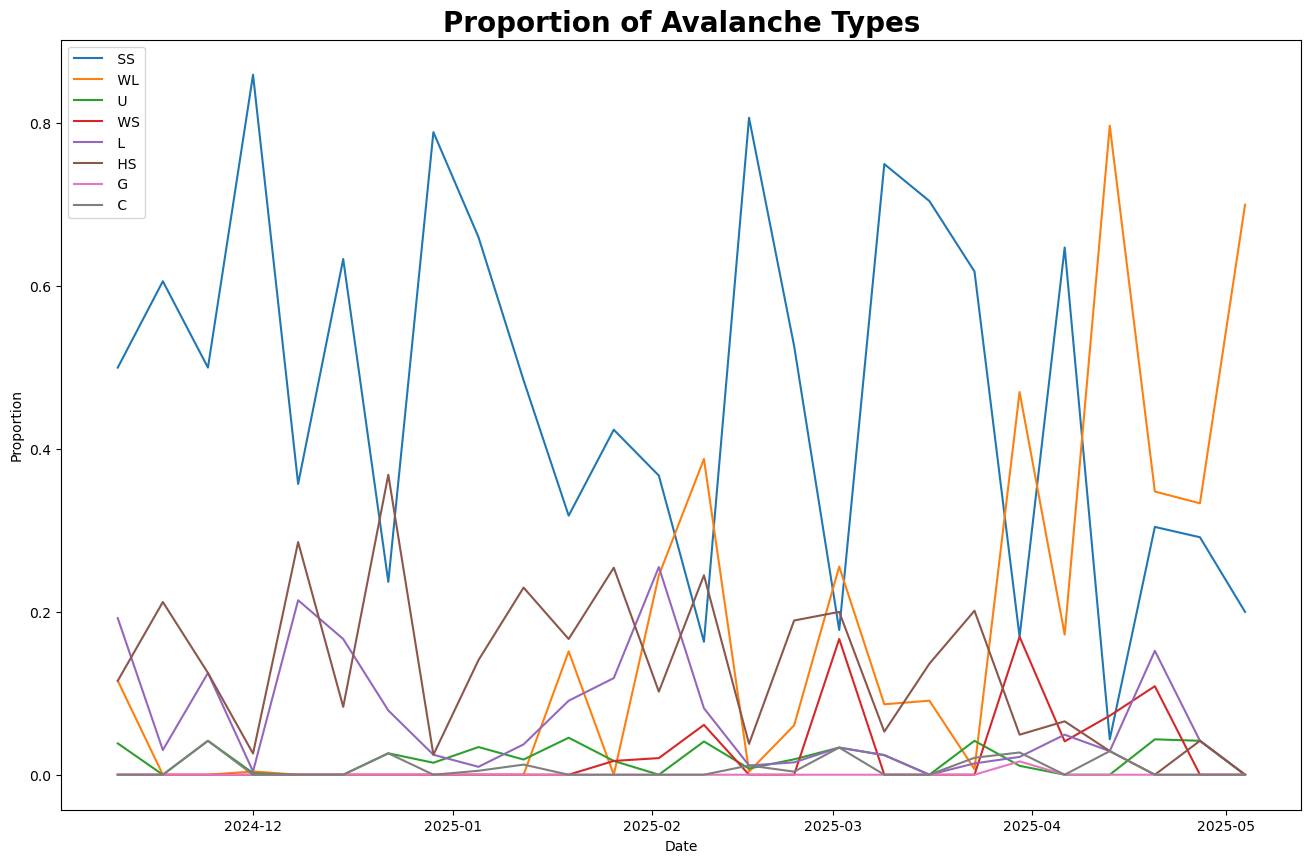

In [57]:
#x_values = range(len(aval_prop[0]))
plt.figure(figsize=(16, 10))

for aval_type in aval_prop:
    plt.plot(week_ints, aval_type)

plt.xlabel("Date")
plt.ylabel("Proportion")
plt.title("Proportion of Avalanche Types", fontsize=20, fontweight='bold')
plt.legend([' SS', ' WL', ' U', ' WS', ' L', ' HS', ' G', ' C'])
# plt.show()
plt.savefig('aval_prop')

In [58]:
def find_surrounding_cells(i, j, max_i, max_j):
    surrounding = []
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            ni, nj = i + di, j + dj
            if 0 <= ni < max_i and 0 <= nj < max_j:
                surrounding.append((int(ni), int(nj)))
    return surrounding

find_surrounding_cells(42, 20, 45, 29)

[(41, 19),
 (41, 20),
 (41, 21),
 (42, 19),
 (42, 20),
 (42, 21),
 (43, 19),
 (43, 20),
 (43, 21)]

In [59]:
lon_edges = np.arange(-100.5, -111.5 - 0.25, -0.25)
lat_edges = np.arange(35.5, 42.5 + 0.25, 0.25)

lon_edges



array([-100.5 , -100.75, -101.  , -101.25, -101.5 , -101.75, -102.  ,
       -102.25, -102.5 , -102.75, -103.  , -103.25, -103.5 , -103.75,
       -104.  , -104.25, -104.5 , -104.75, -105.  , -105.25, -105.5 ,
       -105.75, -106.  , -106.25, -106.5 , -106.75, -107.  , -107.25,
       -107.5 , -107.75, -108.  , -108.25, -108.5 , -108.75, -109.  ,
       -109.25, -109.5 , -109.75, -110.  , -110.25, -110.5 , -110.75,
       -111.  , -111.25, -111.5 ])

In [60]:
avalanche_cells = set()
for lon, lat in zip(aval_2025['Longitude'], aval_2025['latitude']):
    lon_index = np.where((float(lon) <= lon_edges[:-1]) & (float(lon) > lon_edges[1:]))[0]
    lat_index = np.where((float(lat) >= lat_edges[:-1]) & (float(lat) < lat_edges[1:]))[0]
    cells = find_surrounding_cells(int(lon_index[0]), int(lat_index[0]), 45, 29)
    for cell in cells:
        avalanche_cells.add(cell)

In [61]:
avalanche_cells = list(avalanche_cells)
avalanche_cells = sorted(avalanche_cells, key=lambda x: x[1])
avalanche_cells = sorted(avalanche_cells, key=lambda x: x[0])
avalanche_cells

[(16, 12),
 (16, 13),
 (16, 14),
 (17, 6),
 (17, 7),
 (17, 8),
 (17, 12),
 (17, 13),
 (17, 14),
 (18, 6),
 (18, 7),
 (18, 8),
 (18, 12),
 (18, 13),
 (18, 14),
 (19, 6),
 (19, 7),
 (19, 8),
 (19, 9),
 (19, 10),
 (19, 12),
 (19, 13),
 (19, 14),
 (19, 15),
 (19, 16),
 (19, 17),
 (19, 18),
 (19, 19),
 (19, 20),
 (20, 8),
 (20, 9),
 (20, 10),
 (20, 14),
 (20, 15),
 (20, 16),
 (20, 17),
 (20, 18),
 (20, 19),
 (20, 20),
 (20, 21),
 (21, 8),
 (21, 9),
 (21, 10),
 (21, 13),
 (21, 14),
 (21, 15),
 (21, 16),
 (21, 17),
 (21, 18),
 (21, 19),
 (21, 20),
 (21, 21),
 (22, 5),
 (22, 6),
 (22, 7),
 (22, 10),
 (22, 11),
 (22, 12),
 (22, 13),
 (22, 14),
 (22, 15),
 (22, 16),
 (22, 17),
 (22, 18),
 (22, 19),
 (22, 20),
 (22, 21),
 (23, 5),
 (23, 6),
 (23, 7),
 (23, 8),
 (23, 9),
 (23, 10),
 (23, 11),
 (23, 12),
 (23, 13),
 (23, 14),
 (23, 15),
 (23, 16),
 (23, 17),
 (23, 18),
 (23, 19),
 (23, 20),
 (23, 21),
 (23, 22),
 (24, 5),
 (24, 6),
 (24, 7),
 (24, 8),
 (24, 9),
 (24, 10),
 (24, 11),
 (24, 12),
 (24

In [62]:
precip_data_24 = xr.open_dataset("../Data/2024_accum1.nc")
inst_data_24 = xr.open_dataset("../Data/2024_instant1.nc")
precip_data_25 = xr.open_dataset("../Data/2025_accum1.nc")
inst_data_25 = xr.open_dataset("../Data/2025_instant1.nc")

precip_data_25

<xarray.Dataset> Size: 30MB
Dimensions:     (valid_time: 2880, latitude: 29, longitude: 45)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 23kB 2025-01-01 ... 2025-04-30T23...
  * latitude    (latitude) float64 232B 42.5 42.25 42.0 ... 36.0 35.75 35.5
  * longitude   (longitude) float64 360B -111.5 -111.2 -111.0 ... -100.8 -100.5
    expver      (valid_time) <U4 46kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 15MB ...
    ssrd        (valid_time, latitude, longitude) float32 15MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-21T03:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [63]:
ds_merged = xr.concat([precip_data_24, precip_data_25], dim = "valid_time") # Assuming 'time' is the dimension to concatenate
ds_merged.to_netcdf('24_25_accum1.nc')
ds_merged = xr.concat([inst_data_24, inst_data_25], dim = "valid_time") # Assuming 'time' is the dimension to concatenate
ds_merged.to_netcdf('24_25_instant1.nc')

In [64]:
for week, group in weekly_groups:
    print(week)

2024-11-10 00:00:00
2024-11-17 00:00:00
2024-11-24 00:00:00
2024-12-01 00:00:00
2024-12-08 00:00:00
2024-12-15 00:00:00
2024-12-22 00:00:00
2024-12-29 00:00:00
2025-01-05 00:00:00
2025-01-12 00:00:00
2025-01-19 00:00:00
2025-01-26 00:00:00
2025-02-02 00:00:00
2025-02-09 00:00:00
2025-02-16 00:00:00
2025-02-23 00:00:00
2025-03-02 00:00:00
2025-03-09 00:00:00
2025-03-16 00:00:00
2025-03-23 00:00:00
2025-03-30 00:00:00
2025-04-06 00:00:00
2025-04-13 00:00:00
2025-04-20 00:00:00
2025-04-27 00:00:00
2025-05-04 00:00:00


In [65]:
accum_data = xr.open_dataset("../Data/24_25_accum1.nc")
inst_data = xr.open_dataset("../Data/24_25_instant1.nc")

accum_data

<xarray.Dataset> Size: 58MB
Dimensions:     (valid_time: 4344, latitude: 37, longitude: 45)
Coordinates:
  * latitude    (latitude) float64 296B 33.5 33.75 34.0 ... 42.0 42.25 42.5
  * longitude   (longitude) float64 360B -111.5 -111.2 -111.0 ... -100.8 -100.5
  * valid_time  (valid_time) datetime64[ns] 35kB 2024-11-01 ... 2025-04-30T23...
    number      int64 8B ...
    expver      (valid_time) <U4 70kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 29MB ...
    ssrd        (valid_time, latitude, longitude) float32 29MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-21T03:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [66]:
aval_count = []
for week, group in weekly_groups:
    aval_count.append(len(group))

len(aval_count)

26

In [67]:

weekly_tp = accum_data['tp'].resample(valid_time='W').sum().mean(dim=['latitude', 'longitude'])[1:-1]
weekly_ssrd = accum_data['ssrd'].resample(valid_time='W').mean().mean(dim=['latitude', 'longitude'])[1:-1]
#weekly_max_windspeed = math.sqrt((inst_data['u10'].resample(valid_time='W').max().mean(dim=['latitude', 'longitude']))^2 + (inst_data['v10'].resample(valid_time='W').max().mean(dim=['latitude', 'longitude']))^2)
weekly_u10 = inst_data['u10'].resample(valid_time='W').max().mean(dim=['latitude', 'longitude'])[1:-1]
weekly_v10 = inst_data['v10'].resample(valid_time='W').max().mean(dim=['latitude', 'longitude'])[1:-1]
weekly_temp = inst_data['v10'].resample(valid_time='W').mean().mean(dim=['latitude', 'longitude'])[1:-1]
weekly_u10

<xarray.DataArray 'u10' (valid_time: 25)> Size: 100B
array([5.9174566, 6.322596 , 7.481215 , 5.9719467, 5.1688123, 6.5639887,
       5.1350975, 5.8207617, 7.8480926, 5.3776875, 5.6293497, 5.375878 ,
       5.7154   , 7.6085086, 6.1090965, 5.885401 , 6.6686378, 7.231811 ,
       8.928989 , 9.789094 , 6.834885 , 8.062787 , 6.983684 , 7.3688965,
       6.2808633], dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 200B 2024-11-10 ... 2025-04-27

In [68]:
elev_by_cell = []

for lon, lat in avalanche_cells:
    elev_by_cell.append(elev_data[lat-4][lon-8])

elev_by_cell

[1997.0884679012345,
 2193.8555827160494,
 1985.5497444444445,
 1745.8875395061727,
 1560.9083567901234,
 1480.1362444444444,
 1945.8470765432098,
 2283.675754320988,
 2276.2790148148147,
 1856.1613,
 1650.6403530864197,
 1601.5344802469135,
 2174.2888790123457,
 2548.9333679012348,
 2973.1844592592593,
 2137.1765604938273,
 2302.2863814814814,
 2304.28915308642,
 2202.8407567901236,
 2435.6768580246912,
 2595.431250617284,
 2653.390802469136,
 2664.297088888889,
 2398.8828913580246,
 2201.724603703704,
 2579.673996296296,
 2724.8343839506174,
 2960.3027432098766,
 2617.866403703704,
 3098.5522666666666,
 3221.702954320988,
 3070.8784962962964,
 2838.553654320988,
 2825.88107654321,
 2343.899309876543,
 3059.813564197531,
 2738.041964197531,
 2476.92475308642,
 2339.0773,
 2339.597024691358,
 3181.6495938271605,
 2700.550307407407,
 3128.0255469135805,
 2848.26054691358,
 2844.0311074074075,
 2797.8199481481483,
 2666.49542345679,
 2496.7493962962963,
 2305.2410148148147,
 2305.2964197

In [69]:
weekly_tp = accum_data.tp.resample(valid_time="W").sum()[1:-1]
weekly_ssrd = accum_data.ssrd.resample(valid_time="W").mean()[1:-1]
weekly_u10 = inst_data.u10.resample(valid_time="W").max()[1:-1]
weekly_v10 = inst_data.v10.resample(valid_time="W").max()[1:-1]
weekly_temp = inst_data.t2m.resample(valid_time="W").mean()[1:-1]

weekly_tp

<xarray.DataArray 'tp' (valid_time: 25, latitude: 37, longitude: 45)> Size: 166kB
array([[[1.39045715e-03, 2.79712677e-03, 4.06837463e-03, ...,
         6.76493645e-02, 9.43179131e-02, 1.13728046e-01],
        [2.36177444e-03, 3.98254395e-03, 5.32531738e-03, ...,
         6.67662621e-02, 9.08451080e-02, 1.26947403e-01],
        [3.04126740e-03, 4.65965271e-03, 5.74159622e-03, ...,
         6.82067871e-02, 8.05087090e-02, 1.20739937e-01],
        ...,
        [5.66864014e-03, 5.52511215e-03, 3.17239761e-03, ...,
         2.52075195e-02, 2.47974396e-02, 2.42242813e-02],
        [5.35011292e-03, 6.34860992e-03, 5.69963455e-03, ...,
         2.04024315e-02, 1.81007385e-02, 1.87869072e-02],
        [6.48212433e-03, 6.42299652e-03, 6.24608994e-03, ...,
         1.63903236e-02, 1.61228180e-02, 1.67646408e-02]],

       [[2.44140625e-04, 3.89099121e-04, 4.75883484e-04, ...,
         2.96068192e-03, 3.06081772e-03, 2.32410431e-03],
        [2.27451324e-04, 6.28471375e-04, 8.60691071e-04, ...,
         3.32069397e-03, 3.47900391e-03, 3.27253342e-03],
        [1.31607056e-04, 5.31196594e-04, 8.10146332e-04, ...,
         2.96878815e-03, 3.41749191e-03, 4.15754318e-03],
...
         1.58786774e-03, 2.08663940e-03, 2.40516663e-03],
        [1.36766434e-02, 1.07550621e-02, 9.65023041e-03, ...,
         1.45339966e-03, 1.18589401e-03, 1.52730942e-03],
        [1.24926567e-02, 1.25684738e-02, 1.42712593e-02, ...,
         2.33364105e-03, 1.95121765e-03, 1.38187408e-03]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [7.92217255e-03, 1.00016594e-02, 9.71078873e-03, ...,
         8.06283951e-03, 1.08122826e-02, 1.43351555e-02],
        [1.06487274e-02, 8.36467743e-03, 7.95269012e-03, ...,
         6.58702850e-03, 7.29274750e-03, 8.73184204e-03],
        [9.46569443e-03, 8.08811188e-03, 9.43088531e-03, ...,
         8.83579254e-03, 1.24378204e-02, 9.77993011e-03]]],
      shape=(25, 37, 45), dtype=float32)
Coordinates:
  * latitude    (latitude) float64 296B 33.5 33.75 34.0 ... 42.0 42.25 42.5
  * longitude   (longitude) float64 360B -111.5 -111.2 -111.0 ... -100.8 -100.5
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 200B 2024-11-10 ... 2025-04-27
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1665
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [70]:
weekly_wind = np.sqrt((weekly_u10 ** 2) + (weekly_v10 ** 2))
weekly_wind

<xarray.DataArray (valid_time: 25, latitude: 37, longitude: 45)> Size: 166kB
array([[[ 2.889225 ,  3.2896886,  3.6098738, ..., 11.282794 ,
         11.092515 , 10.460564 ],
        [ 2.9688663,  2.9854388,  3.324517 , ..., 11.9010935,
         11.603855 , 10.720745 ],
        [ 3.0768373,  3.1575625,  3.5759277, ..., 12.363719 ,
         11.547507 , 10.721902 ],
        ...,
        [ 4.6303544,  4.6248636,  5.5806017, ...,  6.8266635,
          6.6924267,  6.549915 ],
        [ 4.730069 ,  4.2438526,  4.5327473, ...,  6.965016 ,
          6.8683944,  6.8855934],
        [ 4.346148 ,  4.2210546,  4.616197 , ...,  7.231062 ,
          7.2717657,  6.9707336]],

       [[ 4.6447425,  4.889139 ,  5.2938895, ...,  9.709018 ,
          9.426211 ,  9.381327 ],
        [ 4.764184 ,  4.5604143,  5.3508005, ..., 10.136262 ,
          9.935168 ,  9.688213 ],
        [ 4.6978316,  4.9523044,  6.0829844, ..., 10.506039 ,
         10.197688 ,  9.826446 ],
...
        [ 4.6030216,  4.017268 ,  5.085015 , ...,  9.907328 ,
         10.01536  , 10.082652 ],
        [ 4.897564 ,  4.4910784,  5.2633276, ...,  9.665407 ,
          9.825049 ,  9.873019 ],
        [ 4.8173513,  4.893574 ,  5.640458 , ...,  9.684061 ,
          9.707327 ,  9.728193 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ 6.1663475,  5.3481503,  6.823526 , ..., 13.07807  ,
         13.246727 , 13.498071 ],
        [ 5.8932247,  5.5901804,  6.413012 , ..., 13.238807 ,
         13.758824 , 13.310773 ],
        [ 6.0323415,  6.209831 ,  6.8821807, ..., 13.596354 ,
         13.527557 , 13.064421 ]]], shape=(25, 37, 45), dtype=float32)
Coordinates:
  * latitude    (latitude) float64 296B 33.5 33.75 34.0 ... 42.0 42.25 42.5
  * longitude   (longitude) float64 360B -111.5 -111.2 -111.0 ... -100.8 -100.5
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 200B 2024-11-10 ... 2025-04-27

In [71]:
weekly_tp.sel(valid_time='2024-11-10', latitude=42.5, longitude=-111.5, method='nearest').item()

0.006482124328613281

In [72]:
first_group = next(iter(weekly_groups))
first_group[0]


Timestamp('2024-11-10 00:00:00')

In [73]:
week_timestamp = []
week_label = []
for week, group in weekly_groups:
    week_timestamp.append(week)
    week_label.append(str(week)[:10])

week_label

['2024-11-10',
 '2024-11-17',
 '2024-11-24',
 '2024-12-01',
 '2024-12-08',
 '2024-12-15',
 '2024-12-22',
 '2024-12-29',
 '2025-01-05',
 '2025-01-12',
 '2025-01-19',
 '2025-01-26',
 '2025-02-02',
 '2025-02-09',
 '2025-02-16',
 '2025-02-23',
 '2025-03-02',
 '2025-03-09',
 '2025-03-16',
 '2025-03-23',
 '2025-03-30',
 '2025-04-06',
 '2025-04-13',
 '2025-04-20',
 '2025-04-27',
 '2025-05-04']

In [74]:
for week, group in weekly_groups:
    if week == week_label[5]:
        print("yes")

 SS Week 0:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.053
Model:                              OLS   Adj. R-squared (uncentered):              0.030
Method:                   Least Squares   F-statistic:                              2.255
Date:                  Thu, 22 May 2025   Prob (F-statistic):                      0.0504
Time:                          11:17:09   Log-Likelihood:                          60.891
No. Observations:                   205   AIC:                                     -111.8
Df Residuals:                       200   BIC:                                     -95.17
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


 HS Week 24:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.015
Model:                              OLS   Adj. R-squared (uncentered):             -0.010
Method:                   Least Squares   F-statistic:                             0.6020
Date:                  Thu, 22 May 2025   Prob (F-statistic):                       0.698
Time:                          11:17:32   Log-Likelihood:                          256.26
No. Observations:                   205   AIC:                                     -502.5
Df Residuals:                       200   BIC:                                     -485.9
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


 WL Week 0:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.034
Model:                              OLS   Adj. R-squared (uncentered):              0.010
Method:                   Least Squares   F-statistic:                              1.417
Date:                  Thu, 22 May 2025   Prob (F-statistic):                       0.220
Time:                          11:17:33   Log-Likelihood:                          187.25
No. Observations:                   205   AIC:                                     -364.5
Df Residuals:                       200   BIC:                                     -347.9
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar div

                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                     nan
Model:                              OLS   Adj. R-squared (uncentered):                nan
Method:                   Least Squares   F-statistic:                                nan
Date:                  Thu, 22 May 2025   Prob (F-statistic):                         nan
Time:                          11:17:34   Log-Likelihood:                             inf
No. Observations:                   205   AIC:                                       -inf
Df Residuals:                       200   BIC:                                       -inf
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar div

 WL Week 6:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                     nan
Model:                              OLS   Adj. R-squared (uncentered):                nan
Method:                   Least Squares   F-statistic:                                nan
Date:                  Thu, 22 May 2025   Prob (F-statistic):                         nan
Time:                          11:17:36   Log-Likelihood:                             inf
No. Observations:                   205   AIC:                                       -inf
Df Residuals:                       200   BIC:                                       -inf
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar div

 WL Week 9:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                     nan
Model:                              OLS   Adj. R-squared (uncentered):                nan
Method:                   Least Squares   F-statistic:                                nan
Date:                  Thu, 22 May 2025   Prob (F-statistic):                         nan
Time:                          11:17:37   Log-Likelihood:                             inf
No. Observations:                   205   AIC:                                       -inf
Df Residuals:                       200   BIC:                                       -inf
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar div

 WL Week 12:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.065
Model:                              OLS   Adj. R-squared (uncentered):              0.041
Method:                   Least Squares   F-statistic:                              2.767
Date:                  Thu, 22 May 2025   Prob (F-statistic):                      0.0193
Time:                          11:17:39   Log-Likelihood:                          77.927
No. Observations:                   205   AIC:                                     -145.9
Df Residuals:                       200   BIC:                                     -129.2
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

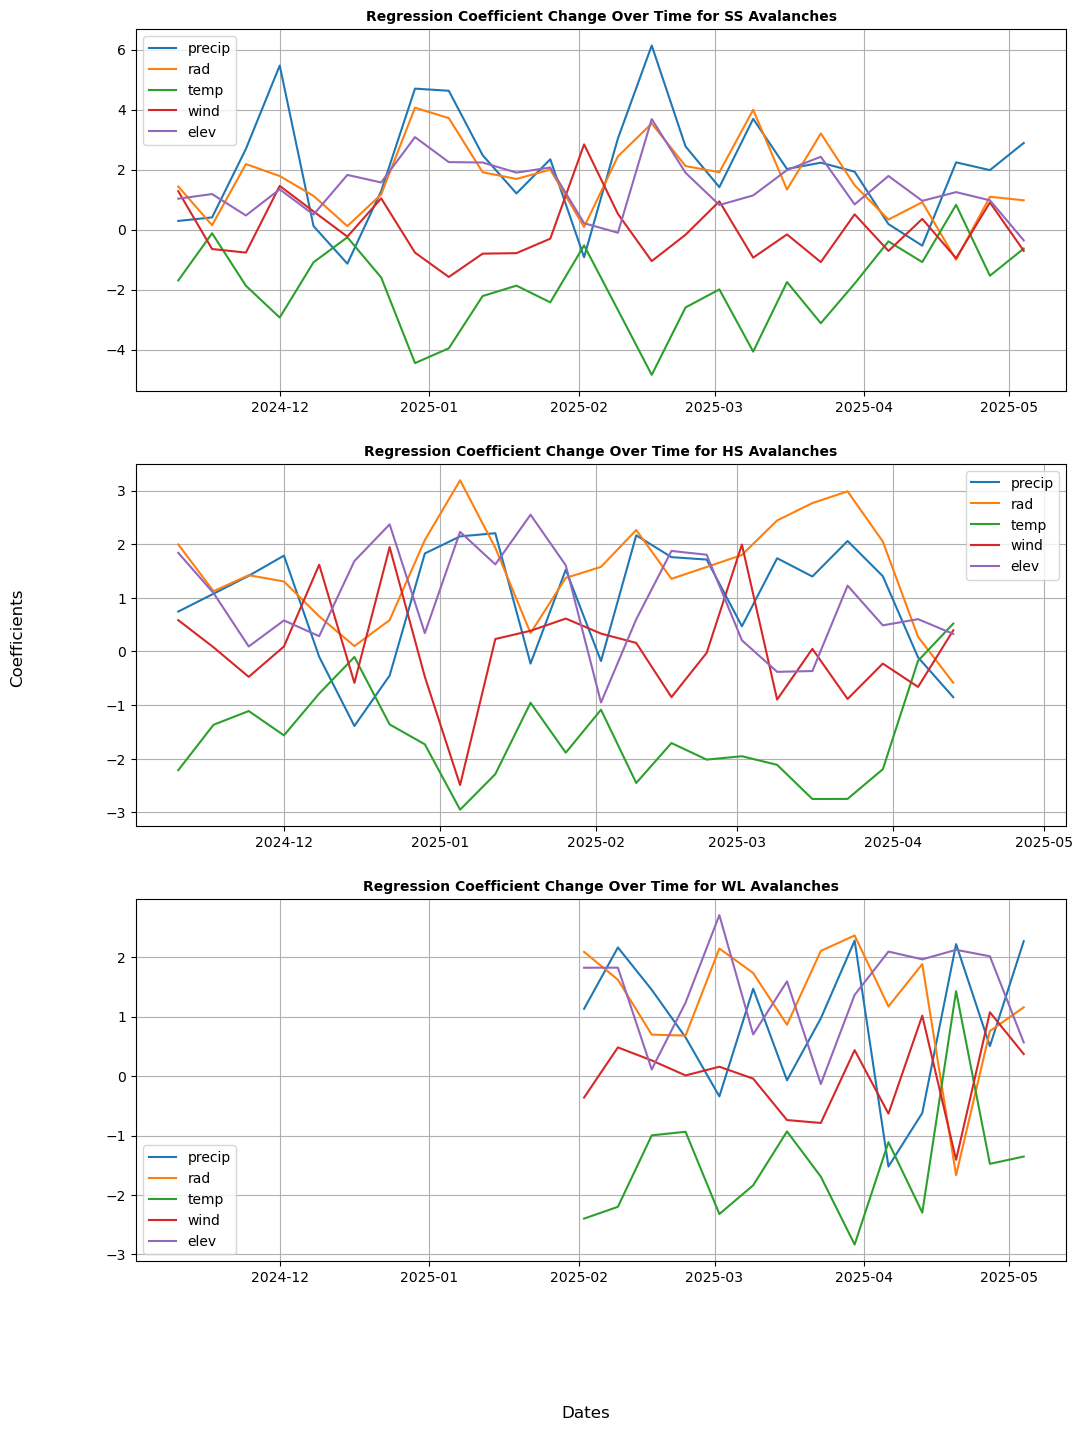

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))
fig.supxlabel('Dates')
fig.supylabel('Coefficients')
col_names = []
for week, group in weekly_groups:
    col_names.append(week)

for axis, aval_type in zip([ax1, ax2, ax3], [' SS', ' HS', ' WL']):
    params = []
    for i in range(len(weekly_groups)):
        avalanche_count = []
        precip_by_cell = []
        rad_by_cell = []
        temp_by_cell = []
        wind_by_cell =[]
        for week, group in weekly_groups:
            if week == week_timestamp[i]:
                group = group[group["Type"] == aval_type]
                # print(group)
                float_lon = [float(x) for x in group['Longitude']]
                float_lat = [float(x) for x in group['latitude']] 
                for lon, lat in avalanche_cells:
                    count = len(group[((float_lon <= lon_edges[lon]) & (float_lon >= lon_edges[lon+1])) &
                                        ((float_lat >= lat_edges[lat]) & (float_lat <= lat_edges[lat+1]))])
                    avalanche_count.append(count)
                    precip_by_cell.append(weekly_tp.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    rad_by_cell.append(weekly_ssrd.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    temp_by_cell.append(weekly_temp.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    wind_by_cell.append(weekly_wind.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
        df = pd.DataFrame({'avalanche_count': avalanche_count, 'precip': precip_by_cell, 'rad': rad_by_cell, 'temp': temp_by_cell, 'wind': wind_by_cell,'elev': elev_by_cell})
        df['rad'] /= 3600 
        df['elev'] /= 1000  

        df['avalanche_occurrence'] = (df['avalanche_count'] >= 1).astype(int)

        logistic_model = sm.OLS(df['avalanche_occurrence'], df[['precip', 'rad', 'temp', 'wind', 'elev']]).fit()

        print(aval_type + " Week " + str(i) + ":")
        print(logistic_model.summary())
        params.append(logistic_model.tvalues)

    df_2 = pd.concat(params, axis = 1)
    df_2.columns = col_names
    df_2 = df_2.T
    #df_2["precip"] = df_2["precip"] / 1000
    for row_name in ['precip', 'rad', 'temp', 'wind', 'elev']:
        axis.plot(df_2.index, df_2[row_name], label=row_name)

    axis.set_title('Regression Coefficient Change Over Time for' + aval_type + ' Avalanches', fontsize=10, fontweight='bold')
    axis.legend()
    axis.grid(True)

# plt.savefig('coefficient_change.png')


 SS Week 0:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.053
Model:                              OLS   Adj. R-squared (uncentered):              0.030
Method:                   Least Squares   F-statistic:                              2.255
Date:                  Thu, 22 May 2025   Prob (F-statistic):                      0.0504
Time:                          12:53:01   Log-Likelihood:                          60.891
No. Observations:                   205   AIC:                                     -111.8
Df Residuals:                       200   BIC:                                     -95.17
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


 HS Week 24:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.015
Model:                              OLS   Adj. R-squared (uncentered):             -0.010
Method:                   Least Squares   F-statistic:                             0.6020
Date:                  Thu, 22 May 2025   Prob (F-statistic):                       0.698
Time:                          12:53:27   Log-Likelihood:                          256.26
No. Observations:                   205   AIC:                                     -502.5
Df Residuals:                       200   BIC:                                     -485.9
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


 WL Week 0:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.034
Model:                              OLS   Adj. R-squared (uncentered):              0.010
Method:                   Least Squares   F-statistic:                              1.417
Date:                  Thu, 22 May 2025   Prob (F-statistic):                       0.220
Time:                          12:53:28   Log-Likelihood:                          187.25
No. Observations:                   205   AIC:                                     -364.5
Df Residuals:                       200   BIC:                                     -347.9
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


 WL Week 2:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                     nan
Model:                              OLS   Adj. R-squared (uncentered):                nan
Method:                   Least Squares   F-statistic:                                nan
Date:                  Thu, 22 May 2025   Prob (F-statistic):                         nan
Time:                          12:53:30   Log-Likelihood:                             inf
No. Observations:                   205   AIC:                                       -inf
Df Residuals:                       200   BIC:                                       -inf
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar div

 WL Week 5:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                     nan
Model:                              OLS   Adj. R-squared (uncentered):                nan
Method:                   Least Squares   F-statistic:                                nan
Date:                  Thu, 22 May 2025   Prob (F-statistic):                         nan
Time:                          12:53:31   Log-Likelihood:                             inf
No. Observations:                   205   AIC:                                       -inf
Df Residuals:                       200   BIC:                                       -inf
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar div

 WL Week 8:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                     nan
Model:                              OLS   Adj. R-squared (uncentered):                nan
Method:                   Least Squares   F-statistic:                                nan
Date:                  Thu, 22 May 2025   Prob (F-statistic):                         nan
Time:                          12:53:32   Log-Likelihood:                             inf
No. Observations:                   205   AIC:                                       -inf
Df Residuals:                       200   BIC:                                       -inf
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar div

 WL Week 11:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                     nan
Model:                              OLS   Adj. R-squared (uncentered):                nan
Method:                   Least Squares   F-statistic:                                nan
Date:                  Thu, 22 May 2025   Prob (F-statistic):                         nan
Time:                          12:53:34   Log-Likelihood:                             inf
No. Observations:                   205   AIC:                                       -inf
Df Residuals:                       200   BIC:                                       -inf
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


 WL Week 12:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.065
Model:                              OLS   Adj. R-squared (uncentered):              0.041
Method:                   Least Squares   F-statistic:                              2.767
Date:                  Thu, 22 May 2025   Prob (F-statistic):                      0.0193
Time:                          12:53:34   Log-Likelihood:                          77.927
No. Observations:                   205   AIC:                                     -145.9
Df Residuals:                       200   BIC:                                     -129.2
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

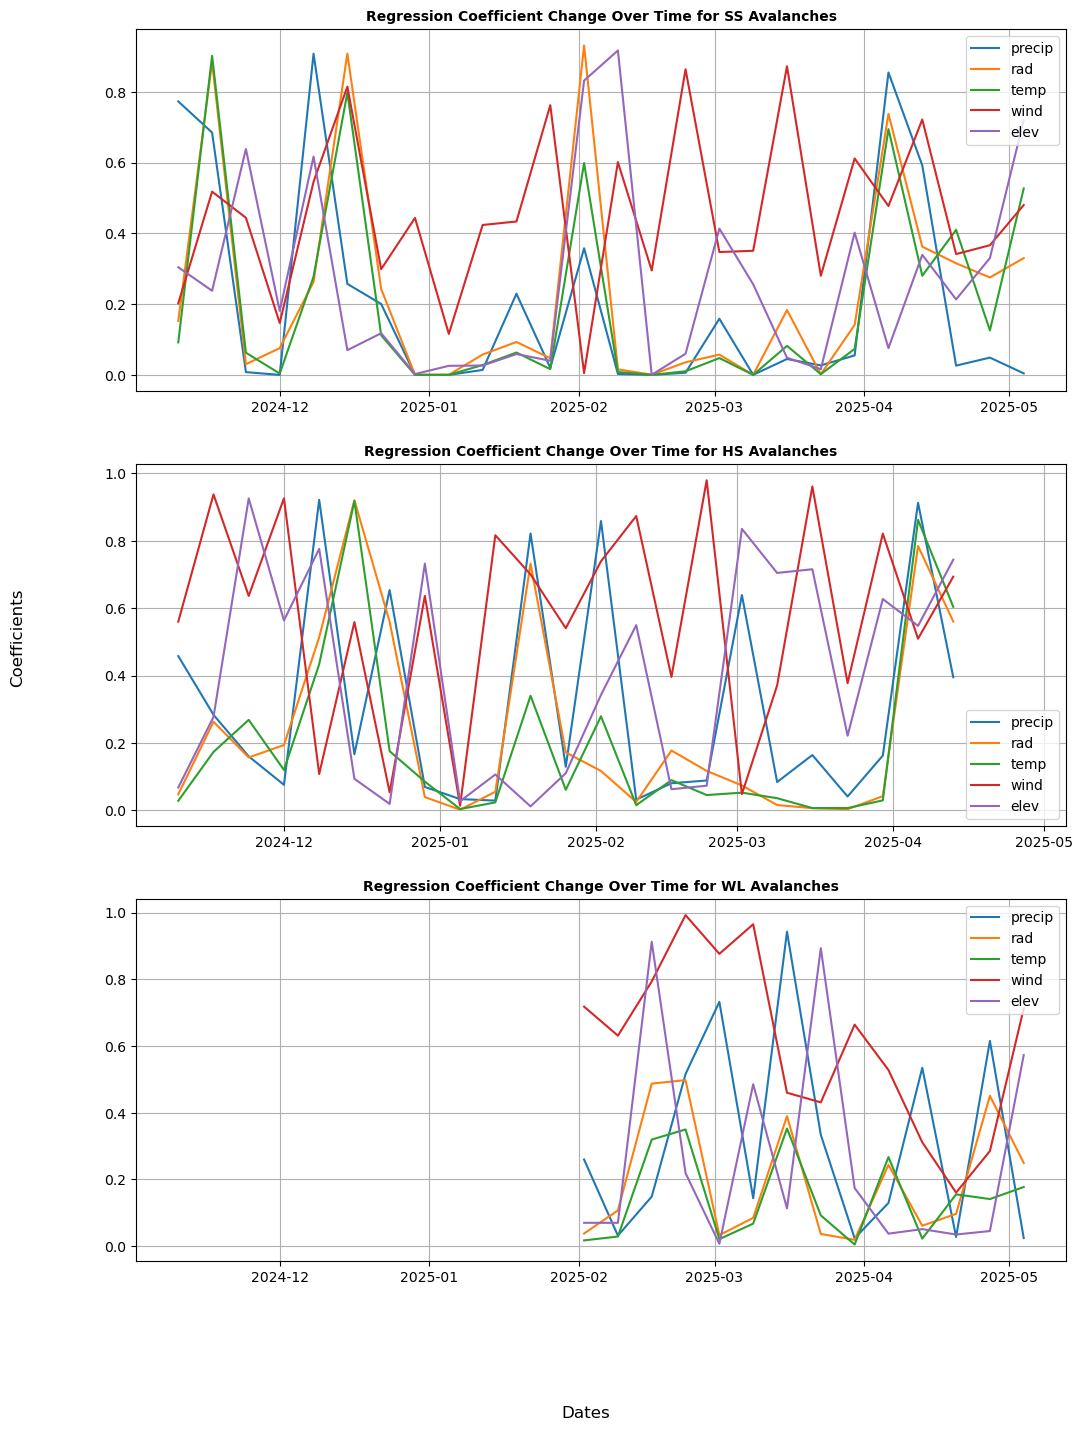

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))
fig.supxlabel('Dates')
fig.supylabel('Coefficients')
col_names = []
for week, group in weekly_groups:
    col_names.append(week)

for axis, aval_type in zip([ax1, ax2, ax3], [' SS', ' HS', ' WL']):
    params = []
    for i in range(len(weekly_groups)):
        avalanche_count = []
        precip_by_cell = []
        rad_by_cell = []
        temp_by_cell = []
        wind_by_cell =[]
        for week, group in weekly_groups:
            if week == week_timestamp[i]:
                group = group[group["Type"] == aval_type]
                # print(group)
                float_lon = [float(x) for x in group['Longitude']]
                float_lat = [float(x) for x in group['latitude']] 
                for lon, lat in avalanche_cells:
                    count = len(group[((float_lon <= lon_edges[lon]) & (float_lon >= lon_edges[lon+1])) &
                                        ((float_lat >= lat_edges[lat]) & (float_lat <= lat_edges[lat+1]))])
                    avalanche_count.append(count)
                    precip_by_cell.append(weekly_tp.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    rad_by_cell.append(weekly_ssrd.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    temp_by_cell.append(weekly_temp.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    wind_by_cell.append(weekly_wind.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
        df = pd.DataFrame({'avalanche_count': avalanche_count, 'precip': precip_by_cell, 'rad': rad_by_cell, 'temp': temp_by_cell, 'wind': wind_by_cell,'elev': elev_by_cell})
        df['rad'] /= 3600 
        df['elev'] /= 1000  

        df['avalanche_occurrence'] = (df['avalanche_count'] >= 1).astype(int)

        logistic_model = sm.OLS(df['avalanche_occurrence'], df[['precip', 'rad', 'temp', 'wind', 'elev']]).fit()

        print(aval_type + " Week " + str(i) + ":")
        print(logistic_model.summary())
        params.append(logistic_model.pvalues)

    df_2 = pd.concat(params, axis = 1)
    df_2.columns = col_names
    df_2 = df_2.T
    #df_2["precip"] = df_2["precip"] / 1000
    for row_name in ['precip', 'rad', 'temp', 'wind', 'elev']:
        axis.plot(df_2.index, df_2[row_name], label=row_name)

    axis.set_title('Regression Coefficient Change Over Time for' + aval_type + ' Avalanches', fontsize=10, fontweight='bold')
    axis.legend()
    axis.grid(True)

# plt.savefig('coefficient_change.png')


 SS Week 0:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                   0.053
Model:                              OLS   Adj. R-squared (uncentered):              0.030
Method:                   Least Squares   F-statistic:                              2.255
Date:                  Thu, 22 May 2025   Prob (F-statistic):                      0.0504
Time:                          11:18:13   Log-Likelihood:                          60.891
No. Observations:                   205   AIC:                                     -111.8
Df Residuals:                       200   BIC:                                     -95.17
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/opt/anaconda3/envs/DRP_env/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar div

 HS Week 25:
                                  OLS Regression Results                                 
Dep. Variable:     avalanche_occurrence   R-squared (uncentered):                     nan
Model:                              OLS   Adj. R-squared (uncentered):                nan
Method:                   Least Squares   F-statistic:                                nan
Date:                  Thu, 22 May 2025   Prob (F-statistic):                         nan
Time:                          11:18:37   Log-Likelihood:                             inf
No. Observations:                   205   AIC:                                       -inf
Df Residuals:                       200   BIC:                                       -inf
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

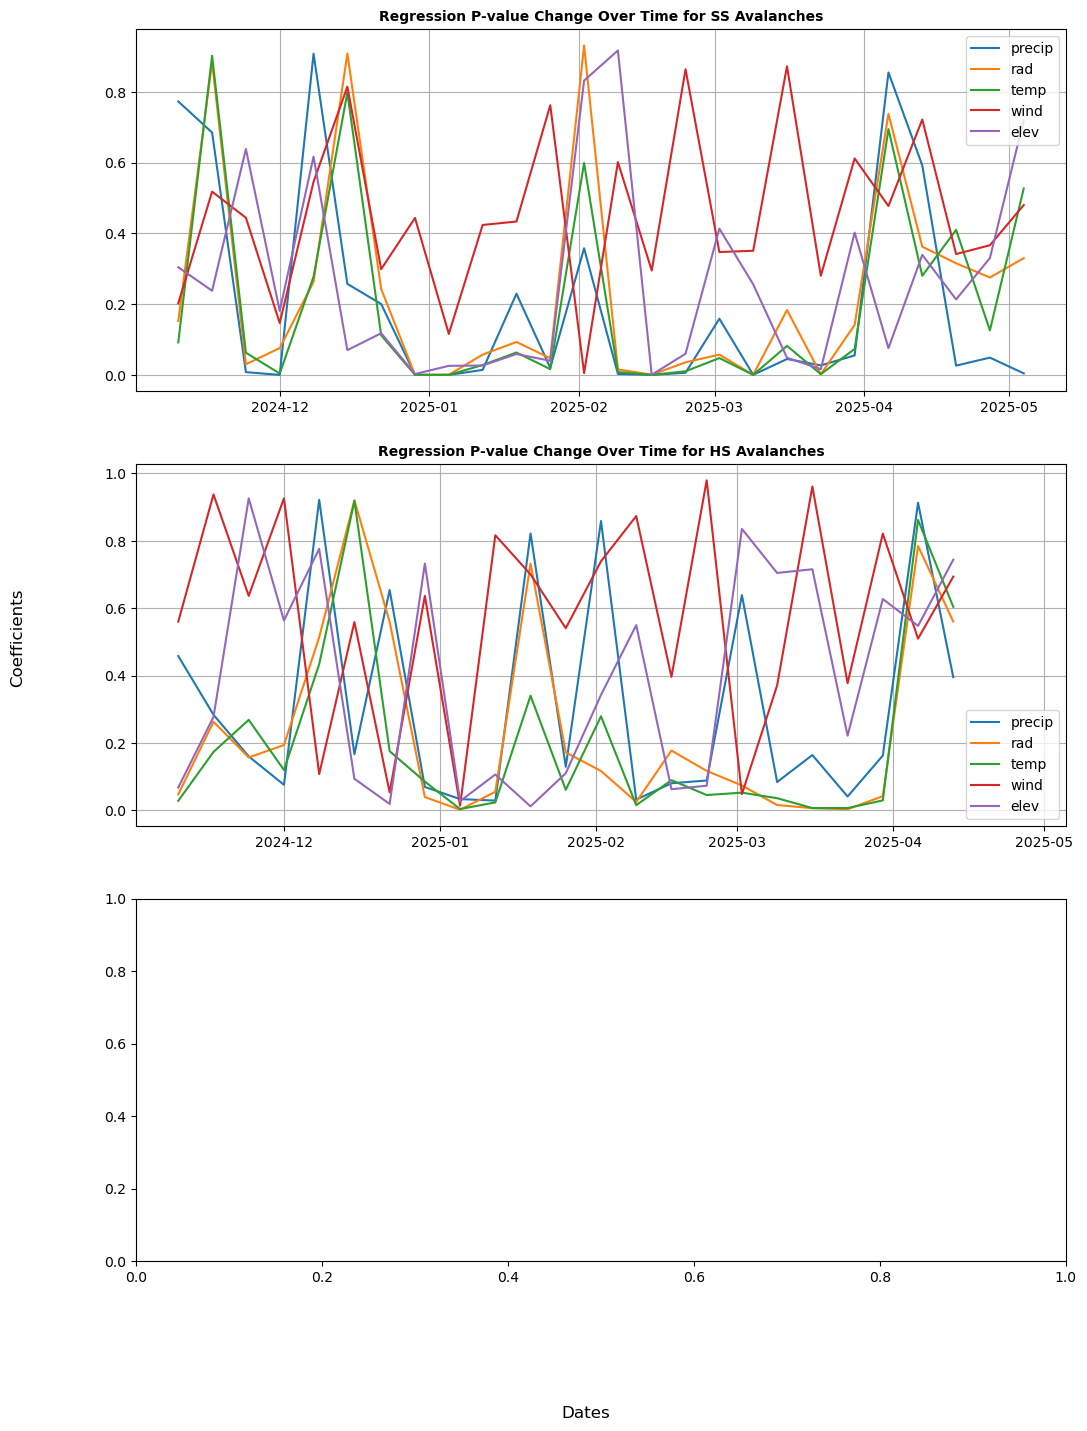

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))
fig.supxlabel('Dates')
fig.supylabel('Coefficients')
col_names = []
for week, group in weekly_groups:
    col_names.append(week)

for axis, aval_type in zip([ax1, ax2, ax3], [' SS', ' HS']):
    params = []
    for i in range(len(weekly_groups)):
        avalanche_count = []
        precip_by_cell = []
        rad_by_cell = []
        temp_by_cell = []
        wind_by_cell =[]
        for week, group in weekly_groups:
            if week == week_timestamp[i]:
                group = group[group["Type"] == aval_type]
                # print(group)
                float_lon = [float(x) for x in group['Longitude']]
                float_lat = [float(x) for x in group['latitude']] 
                for lon, lat in avalanche_cells:
                    count = len(group[((float_lon <= lon_edges[lon]) & (float_lon >= lon_edges[lon+1])) &
                                        ((float_lat >= lat_edges[lat]) & (float_lat <= lat_edges[lat+1]))])
                    avalanche_count.append(count)
                    precip_by_cell.append(weekly_tp.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    rad_by_cell.append(weekly_ssrd.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    temp_by_cell.append(weekly_temp.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
                    wind_by_cell.append(weekly_wind.sel(valid_time=week_label[i], latitude=lat_edges[lat], longitude=lon_edges[lon], method='nearest').item())
        df = pd.DataFrame({'avalanche_count': avalanche_count, 'precip': precip_by_cell, 'rad': rad_by_cell, 'temp': temp_by_cell, 'wind': wind_by_cell,'elev': elev_by_cell})
        df['rad'] /= 3600 
        df['elev'] /= 1000  

        df['avalanche_occurrence'] = (df['avalanche_count'] >= 1).astype(int)

        logistic_model = sm.OLS(df['avalanche_occurrence'], df[['precip', 'rad', 'temp', 'wind', 'elev']]).fit()

        print(aval_type + " Week " + str(i) + ":")
        print(logistic_model.summary())
        params.append(logistic_model.pvalues)

    df_2 = pd.concat(params, axis = 1)
    df_2.columns = col_names
    df_2 = df_2.T
    #df_2["precip"] = df_2["precip"] / 1000
    for row_name in ['precip', 'rad', 'temp', 'wind', 'elev']:
        axis.plot(df_2.index, df_2[row_name], label=row_name)

    axis.set_title('Regression P-value Change Over Time for' + aval_type + ' Avalanches', fontsize=10, fontweight='bold')
    axis.legend()
    axis.grid(True)

# plt.savefig('pval_change.png')

In [ ]:

col_names = []
for week, group in weekly_groups:
    col_names.append(week)
df_2.columns = col_names
df_2 = df_2.T
df_2["precip"] = df_2["precip"] / 1000
# for i in range(21):
#     col_names.append("week " + str(i))
# df_2.columns = col_names
# df_2

ValueError: Length mismatch: Expected axis has 6 elements, new values have 26 elements

In [ ]:
df_2

,precip,rad,temp,u10,v10,elev
2024-11-10,0.018820,0.061172,-0.057988,0.726379,-0.094250,0.512042
2024-11-17,0.051539,0.011019,-0.019374,-0.219625,-0.174055,0.804772
2024-11-24,1.137650,0.567087,-0.290910,-1.842137,-0.420605,0.941667
2024-12-01,0.120572,0.051679,-0.055444,0.589114,-0.399446,0.937882
2024-12-08,1.187942,0.107911,-0.065439,0.481419,-1.369405,0.052098
2024-12-15,-0.182028,0.008744,-0.024912,0.151410,-0.594514,1.437260
2024-12-22,0.297905,0.108196,-0.094147,0.483428,0.496333,2.037044
2024-12-29,0.401091,0.220387,-0.130182,-0.209454,-0.233614,2.280502
2025-01-05,0.268246,0.179783,-0.091698,-0.168511,-1.190026,1.457353
2025-01-12,0.348088,0.127803,-0.078512,-0.246439,-1.096738,1.287282


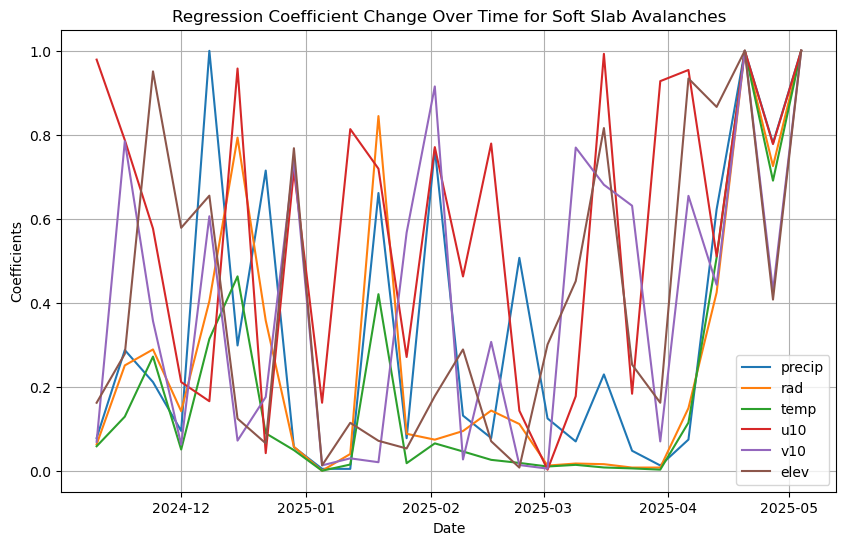

In [ ]:
plt.figure(figsize=(10, 6))
for row_name in ['precip', 'rad', 'temp', 'u10', 'v10', 'elev']:
    #print(row_name)
    plt.plot(df_2.index, df_2[row_name], label=row_name)

plt.xlabel('Date')
plt.ylabel('Coefficients')
plt.title('Regression Coefficient Change Over Time for Soft Slab Avalanches')
plt.legend()
plt.grid(True)
plt.show()